# This notebook ifs for the Course network Analysis - IMD1155 


---


##### Using the dataset from Álvaro F.P.P repository, we will create the an analysis of air trafic on Brazil

---

<p> On first step, import all libraries necessary from analysis </p>
by orientation of the teacher, we will use nxviz on version 0.6.3 because have more stability. </p>

In [ ]:
!pip install nxviz=='0.6.3'

In [195]:
import networkx as nx
import matplotlib.pyplot as plt
import nxviz
import pandas as pd
import seaborn as sns

**Dowloading the dataset repository of air traffic in Flights in Brazil**

initially we can see the dataset have 3 core files

*   air_traffic.graphml
*   airports.csv
*   anac.zip

Importing air_traffic.graphhml

In [224]:
!gdown https://drive.google.com/uc?id=1VbPU9Ms6hHsLpFnniqwWrcpkbPySXqRl

Downloading...
From: https://drive.google.com/uc?id=1VbPU9Ms6hHsLpFnniqwWrcpkbPySXqRl
To: /content/air_traffic.graphml
100% 999k/999k [00:00<00:00, 66.1MB/s]


In [225]:
G = nx.read_graphml("air_traffic.graphml")
for node, data in G.nodes(data=True):
    print(node, data)
    break

KDFW {'name': 'DALLAS & FORT WORTH, TEXAS', 'country': 'ESTADOS UNIDOS DA AMÉRICA', 'latitude': '32.896801', 'longitude': '-97.038002'}


In [226]:
for edge in G.edges(data=True):
    print(edge)
    break

('KDFW', 'KAUS', {'flight_count': 6})


The Graph contains foreign airports, probably international flights with this airports and the edges having flight_count attribute, making the flights<p>

---
In this analysis, we will need the region attribute, but in the main graphic we don't have it, looking at the other files in the dataset, we have the airports.csv file, let's see what it contains

In [227]:
airport = pd.read_csv('airports.csv')
airport.head()

,code,name,state,region,country,continent,Código OACI,lat_geo_point,lon_geo_point
0,KDFW,"DALLAS & FORT WORTH, TEXAS",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,NaN,32.896801,-97.038002
1,KJFK,"NEW YORK, NEW YORK",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,NaN,40.639801,-73.7789
2,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,NaN,25.79319953918457,-80.29060363769531
3,SBCF,CONFINS,MG,SUDESTE,BRASIL,AMÉRICA DO SUL,NaN,-19.62444305419922,-43.97194290161133
4,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,NaN,-22.8099994659,-43.2505569458


See now the region attribute in csv.

For now, we have two tasks before starting the analysis.

*   remove foreing airports from the grapg G
*   add region attribute in the graph G

**Making the tasks**


removing foreing airports from graph G and dataset airport

In [228]:
foreign_airports = []

for node, data in G.nodes(data=True):
    if data['country'] != 'BRASIL':
        foreign_airports.append(node)
        
G.remove_nodes_from(foreign_airports)

airport = airport[airport['country']=="BRASIL"]
airport.head()

,code,name,state,region,country,continent,Código OACI,lat_geo_point,lon_geo_point
3,SBCF,CONFINS,MG,SUDESTE,BRASIL,AMÉRICA DO SUL,NaN,-19.62444305419922,-43.97194290161133
4,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,NaN,-22.8099994659,-43.2505569458
5,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,NaN,-23.435556411743164,-46.47305679321289
7,SSUM,UMUARAMA,PR,SUL,BRASIL,AMÉRICA DO SUL,NaN,-23.7987003326416,-53.31380081176758
10,SNBG,BAIXO GUANDU,ES,SUDESTE,BRASIL,AMÉRICA DO SUL,NaN,-19.499000549316406,-41.04180145263672


---
We can now add the attribute region on graph using the airport


In [229]:
for node, data in G.nodes(data=True):
  data['region'] = airport[airport['code']==node]['region'].iloc[0]

In [230]:
for node, data in G.nodes(data=True):
    print(node, data)
    break

SBCF {'name': 'CONFINS', 'country': 'BRASIL', 'latitude': '-19.62444305419922', 'longitude': '-43.97194290161133', 'region': 'SUDESTE'}


before go to analysis, save the changes

In [233]:
nx.write_graphml(G, 'air_traffic_2.graphml')
airport.to_csv('airports_2.csv')

# **FIRST ANALYSIS**
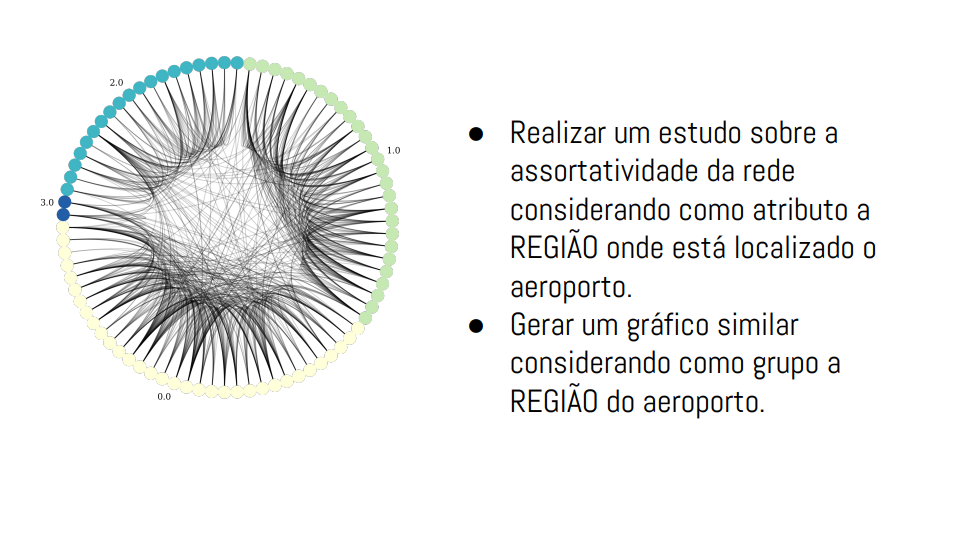

 <h3> We need make a study on assortativity with the attribute region and make a similar graph of the assortativity </h3>

---
we will use the circos graph by nxviz to perform a substantial analysis, checking if it has assortativity and the behavior of the relationships of each node

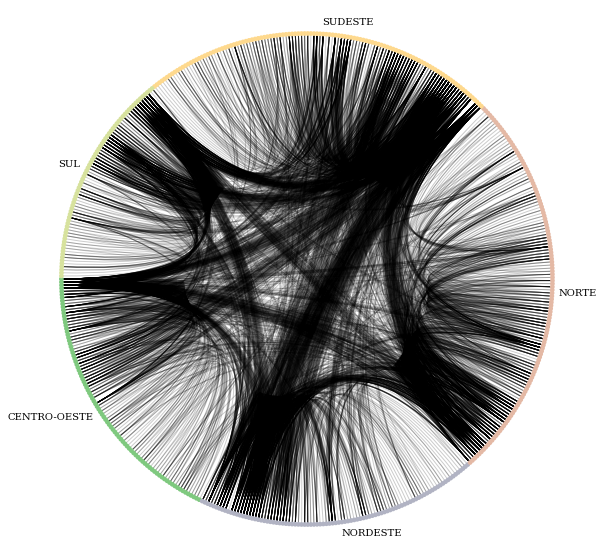

In [14]:
# Create a Circos Plot
circos = nxviz.CircosPlot(
    G,
    node_grouping="region",
    node_color="region",
    group_label_position="middle",
    figsize=(12,10))
circos.draw()
plt.show()
print("Assortativity Coefficient: ", nx.attribute_assortativity_coefficient(G, "region"))

by the graph and Assortativity Coefficient between 0 and 1, the nodes tend to connect to nodes from the same region, but it is not a totally assortative network, as there are connections between different regions.
<p>
for better visualization, we will create the mixing matrix and heatmap to see the correlation between each region

In [15]:
#fist create the mixing matrix by networkx

mp = {"NORTE":0, "NORDESTE":1, "CENTRO-OESTE":2,"SUDESTE":3,"SUL":4}
mixing_matrix = nx.attribute_mixing_matrix(G,'region', mapping=mp)


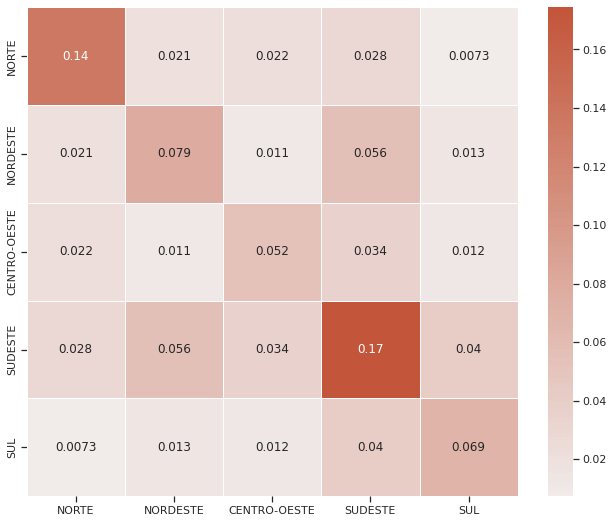

In [16]:
#using seaborn to show heatmap
sns.set_theme(style="ticks")

mp = ['NORTE','NORDESTE','CENTRO-OESTE','SUDESTE','SUL']
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(mixing_matrix, cmap=cmap, vmax=.1745, center=0,
            linewidths=.5, annot=True, xticklabels=mp, yticklabels=mp)

plt.show()

as expected, each region tends to connect with itself, observed by the main diagonal.

# **SECOND ANALYSIS**
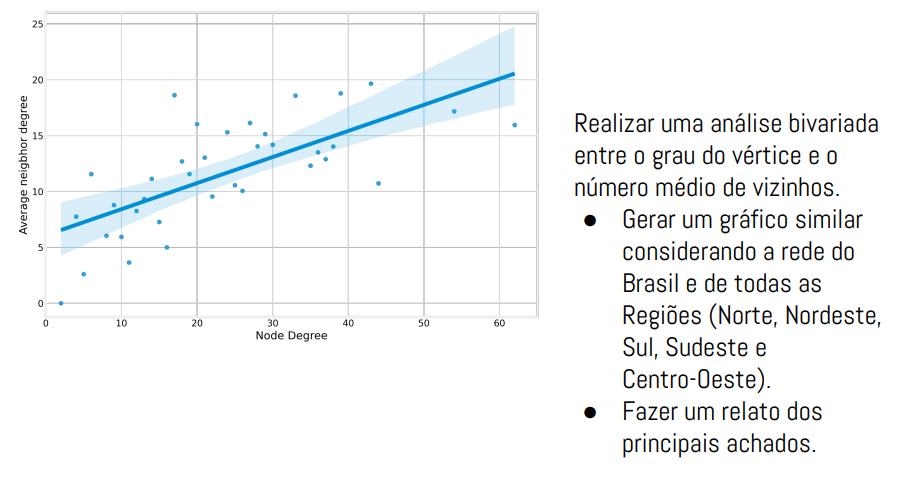

To make the Bivariate analysis, we will use the Scatter plot and the regression plot between node degree and average neigbhor degree of the country and each region.
<p>

The assortativity coefficient can show us whether the behavior of the network is assortative or dissortative (i.e core nodes try to connect with other core nodes or with leaf nodes).
If the assortativity coefficient is between 0 and 1 is assortative, else is dissortative

<br>

---

Let's make firts for the country

In [234]:
degree = []
average_degree = []

for dg, avg in nx.average_degree_connectivity(G).items():
  degree.append(dg)
  average_degree.append(avg)

assortativity_coefficient = nx.degree_assortativity_coefficient(G).round(4)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


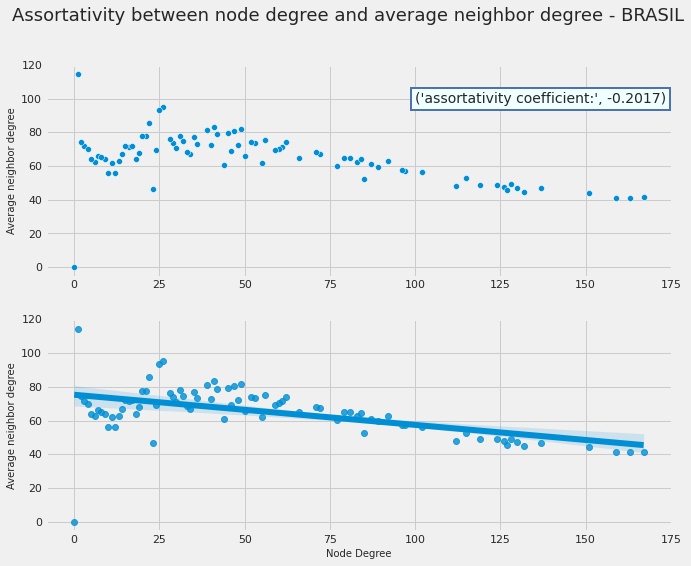

In [328]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

sns.scatterplot(degree,average_degree,ax=ax1)

sns.regplot(degree,average_degree, ax=ax2)

fig.suptitle('Assortativity between node degree and average neighbor degree - BRASIL', fontsize=18)
ax1.text(100, 100, ("assortativity coefficient:" , assortativity_coefficient),ha="left", va="center", bbox=dict(fc="azure", ec="b", lw=2))

ax1.set_ylabel("Average neighbor degree",fontsize=10)
ax2.set_ylabel("Average neighbor degree",fontsize=10)
ax2.set_xlabel("Node Degree", fontsize=10)


plt.show()

Then for the each region

In [274]:
#first we separate each region into sub graphs and calculate de degree anda average.
G = nx.read_graphml('air_traffic_2.graphml')

#to the North
norte = [node for node, data in G.nodes(data=True) if data['region'] != 'NORTE' ]
G.remove_nodes_from(norte)

north_degree = [dg for dg, avg in nx.average_degree_connectivity(G).items()]
north_average_degree = [avg for dg, avg in nx.average_degree_connectivity(G).items()]

north_degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G)


#there are changes in the graph G, we will reload, and this will happen in each region
G = nx.read_graphml('air_traffic_2.graphml')

#to the North East
nordeste = [node for node, data in G.nodes(data=True) if data['region'] != 'NORDESTE' ]
G.remove_nodes_from(nordeste)

northeast_degree = [dg for dg, avg in nx.average_degree_connectivity(G).items()]
northeast_average_degree = [avg for dg, avg in nx.average_degree_connectivity(G).items()]

northeast_degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G)


#reload
G = nx.read_graphml('air_traffic_2.graphml')

#to the Midwest
centrooeste = [node for node, data in G.nodes(data=True) if data['region'] != 'CENTRO-OESTE' ]
G.remove_nodes_from(centrooeste)

midwest_degree = [dg for dg, avg in nx.average_degree_connectivity(G).items()]
midwest_average_degree = [avg for dg, avg in nx.average_degree_connectivity(G).items()]

midwest_degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G)


#reload
G = nx.read_graphml('air_traffic_2.graphml')


#to the South East
sudeste = [node for node, data in G.nodes(data=True) if data['region'] != 'SUDESTE' ]
G.remove_nodes_from(sudeste)

southeast_degree = [dg for dg, avg in nx.average_degree_connectivity(G).items()]
southeast_average_degree = [avg for dg, avg in nx.average_degree_connectivity(G).items()]

southeast_degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G)


#reload
G = nx.read_graphml('air_traffic_2.graphml')

#to the South
sul = [node for node, data in G.nodes(data=True) if data['region'] != 'SUL' ]
G.remove_nodes_from(sul)

south_degree = [dg for dg, avg in nx.average_degree_connectivity(G).items()]
south_average_degree = [avg for dg, avg in nx.average_degree_connectivity(G).items()]

south_degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G)


Now we have all the resoucer to make the regression plot, let's do it

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Assortativity between node degree and average neighbor degree - North region')

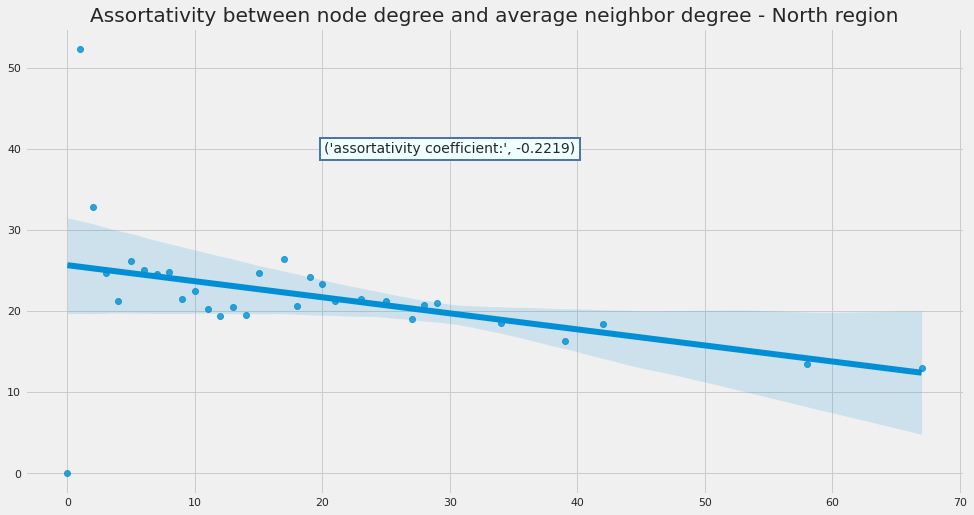

In [322]:
fig, ax1 = plt.subplots(1,1, figsize=(15,8))
sns.regplot(north_degree,north_average_degree, ax=ax1)

ax1.text(30, 40, ("assortativity coefficient:" , north_degree_assortativity_coefficient.round(4)),ha="center", va="center", bbox=dict(fc="azure", ec="b", lw=2))

ax1.set_title('Assortativity between node degree and average neighbor degree - North region')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Assortativity between node degree and average neighbor degree - Northeast region')

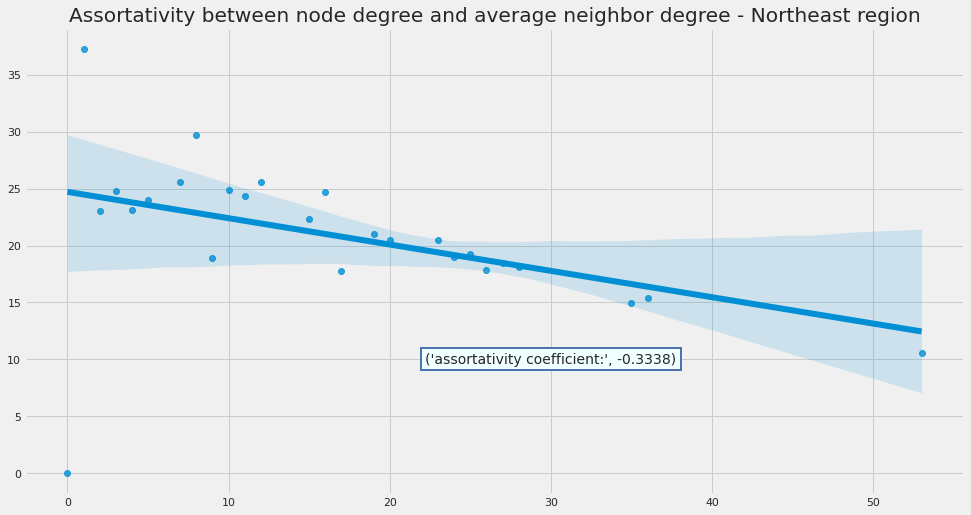

In [323]:
fig, ax2 = plt.subplots(1,1, figsize=(15,8))
sns.regplot(northeast_degree,northeast_average_degree, ax=ax2)
ax2.text(30, 10, ("assortativity coefficient:" , northeast_degree_assortativity_coefficient.round(4)),ha="center", va="center", bbox=dict(fc="azure", ec="b", lw=2))
ax2.set_title('Assortativity between node degree and average neighbor degree - Northeast region')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Assortativity between node degree and average neighbor degree - Midwest region')

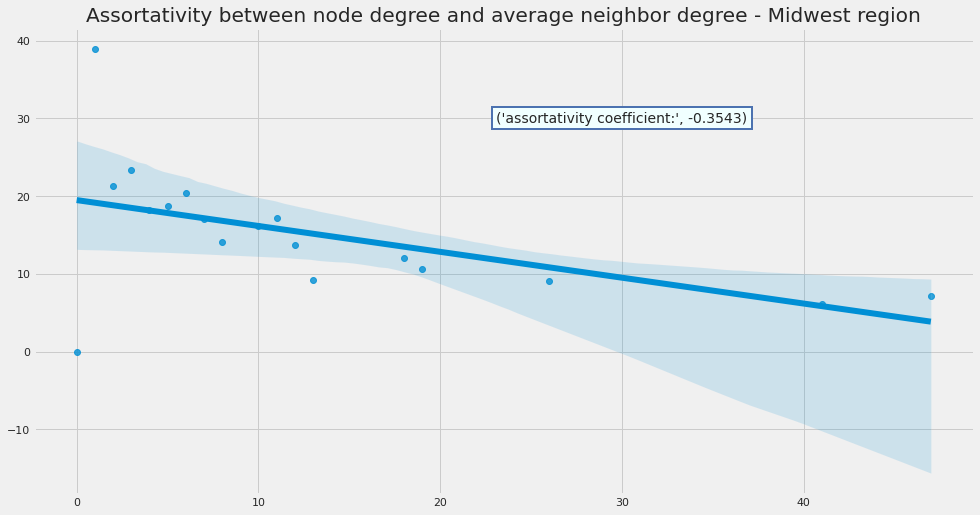

In [324]:
fig, ax3 = plt.subplots(1,1, figsize=(15,8))
sns.regplot(midwest_degree,midwest_average_degree, ax=ax3)
ax3.text(30, 30, ("assortativity coefficient:" , midwest_degree_assortativity_coefficient.round(4)),ha="center", va="center", bbox=dict(fc="azure", ec="b", lw=2))
ax3.set_title('Assortativity between node degree and average neighbor degree - Midwest region')



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Assortativity between node degree and average neighbor degree - Southeast region')

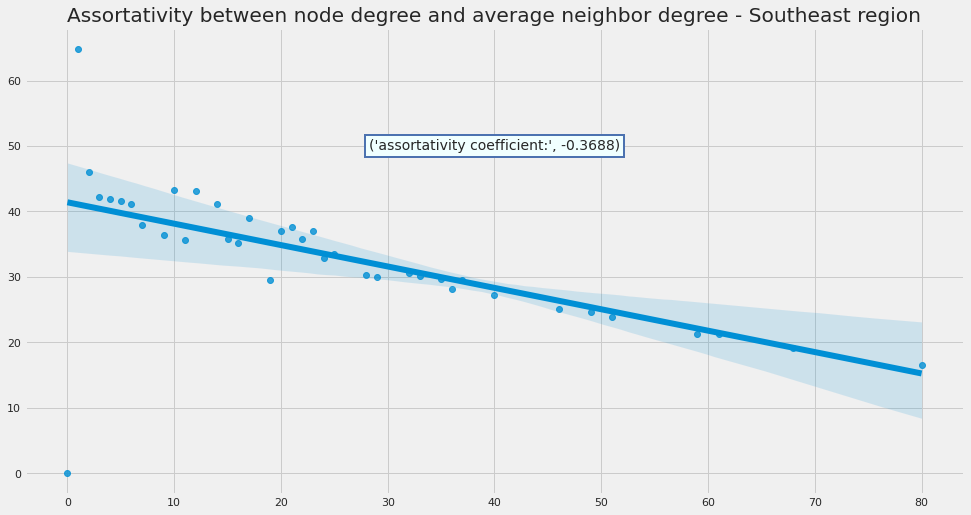

In [325]:
fig, ax4 = plt.subplots(1,1, figsize=(15,8))

sns.regplot(southeast_degree,southeast_average_degree, ax=ax4)

ax4.text(40, 50, ("assortativity coefficient:" , southeast_degree_assortativity_coefficient.round(4)),ha="center", va="center", bbox=dict(fc="azure", ec="b", lw=2))

ax4.set_title('Assortativity between node degree and average neighbor degree - Southeast region')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


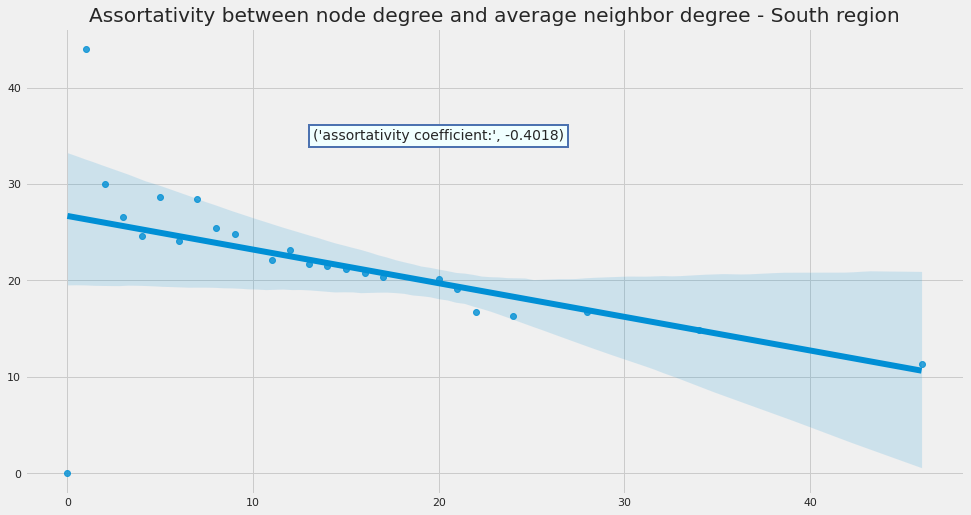

In [329]:

fig, ax5 = plt.subplots(1,1, figsize=(15,8))
sns.regplot(south_degree,south_average_degree, ax=ax5)
ax5.set_title('Assortativity between node degree and average neighbor degree - South region')
ax5.text(20, 35, ("assortativity coefficient:" , south_degree_assortativity_coefficient.round(4)),ha="center", va="center", bbox=dict(fc="azure", ec="b", lw=2))

plt.show()



**Conclusion**
<p>
this network has disassortative characteristics according to the coefficients obtained in each region and in the entire country, i.e, the central nodes tend to connect with the leaves and the opposite happens

---
# **TIRD ANALYSIS**
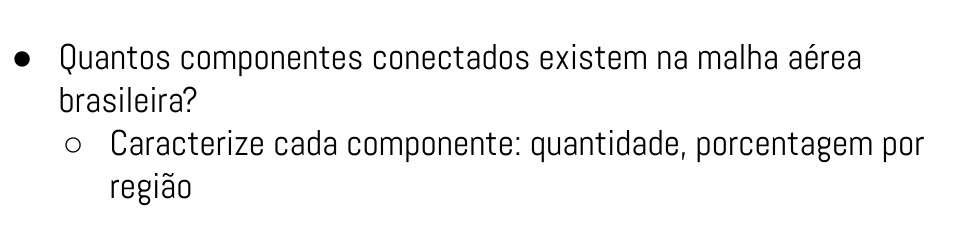

On this step, we need see the components connected in the aerial network, characterized by quantity, percentage per region

In [17]:
#first check if the network is conected
is_connected = nx.is_connected(G)
connected_cores = nx.number_connected_components(G)
print("this network is", "" if is_connected else "not" ,"connected and have", connected_cores, "mesh")

this network is not connected and have 5 mesh


In [18]:
for component in nx.connected_components(G):
  print(component)
print("GCC:" ,len(nx.node_connected_component(G,"SBCF")))

{'SWDE', 'SBEG', 'SWDB', 'SNCC', 'SBVH', 'SBVC', 'SNBU', 'SBTK', 'SNBA', 'SBIL', 'SISO', 'SBRB', 'SWBG', 'SBML', 'SBPM', 'SWVC', 'SBPC', 'SBCN', 'SDZC', 'SNGQ', 'SNBS', 'SNFE', 'SBBI', 'SNJO', 'SSHZ', 'SJLU', 'SSDO', 'SBCJ', 'SDOU', 'SDUN', 'SBGR', 'SNIU', 'SBHT', 'SWBU', 'SWTP', 'SBRG', 'SWJP', 'SWPD', 'SNJM', 'SBGV', 'SBCP', 'SSCP', 'SBMA', 'SBUG', 'SBUY', 'SBGL', 'SNVV', 'SBSO', 'SDFR', 'SBJD', 'SWIQ', 'SNSW', 'SSVI', 'SNGX', 'SBDO', 'SNNG', 'SNTF', 'SJGU', 'SNJB', 'SNPP', 'SDVE', 'SBAU', 'SNDC', 'SWPJ', 'SDDM', 'SBME', 'SBCV', 'SSEP', 'SNMK', '2NHT', 'SBST', 'SBPV', 'SBCF', 'SBKP', 'SBNM', 'SNKK', 'SBJI', 'SNPG', 'SBCB', 'SNQX', 'SDZG', 'SBMQ', 'SJDB', 'SWYK', 'SNMA', 'SSKM', 'SBSV', 'SWNK', 'SIKC', 'SWNH', 'SSIJ', 'SBQV', 'SWWU', 'SWBV', 'SNMD', 'SSUV', 'SNQY', 'SJTS', 'SBLN', 'SBMT', 'SWJV', 'SBDN', 'SBJF', 'SNPY', 'SBJP', 'SBTS', 'SSLT', 'SWNS', 'SNKE', 'SWLB', 'SSAC', 'SJQP', 'SWEE', 'SDAN', 'SILJ', 'SBBQ', 'SBBE', 'SNEB', 'SWJH', 'SBNT', 'SSOG', 'SNOB', 'SBYA', 'SNUB', 'SBJA',

The GCC (Giant Connected Component) contains 491 connected airports and the other networks are individual nodes
<p>

*note*: SNBG, SSBE, SNGR and SBER airports are small airports, operating under VFR (Visual Flight rules) and runways smaller than 2000 meters and do not have a structure to receive medium and large aircraft from airlines, thus being separated from the large network <small>(data obtained by the flightmarket website)

---
to get the percentage per region we will get only de region from the GCC

In [19]:
percentage_by_region = {"code":[], "region":[]}

for node, data in G.nodes(data=True):
  if node in nx.node_connected_component(G,"SBCF"):
    percentage_by_region['code'].append(node)
    percentage_by_region['region'].append(data['region'])

and now create the dataframe to make a plot os the datas

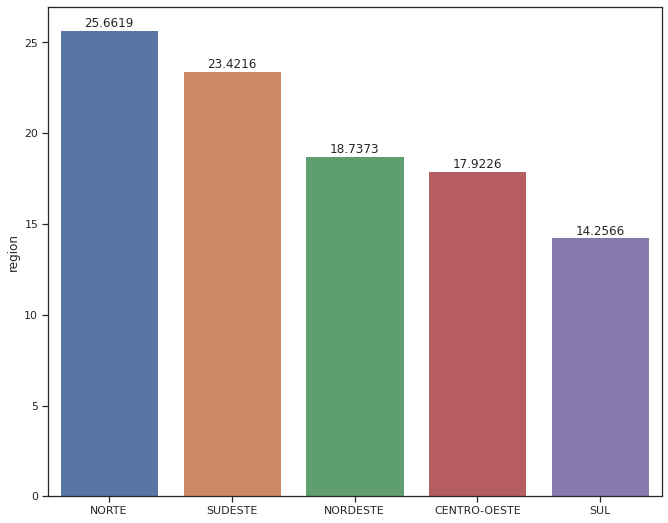

In [21]:
#get dataframe
data = pd.DataFrame(percentage_by_region)

#nomalize data
plotdata = (data['region'].value_counts(normalize=True) * 100)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

#set style
sns.set_style('ticks')

#set barplot
sns.barplot(x = plotdata.index, y = plotdata)

#to show percentage in each bar
ax.bar_label(ax.containers[0])

plt.show()

In GCC, the most airports aer in north region with 25,6619% and the less is in south with 14,2566%

# FOURTH ANALYSIS
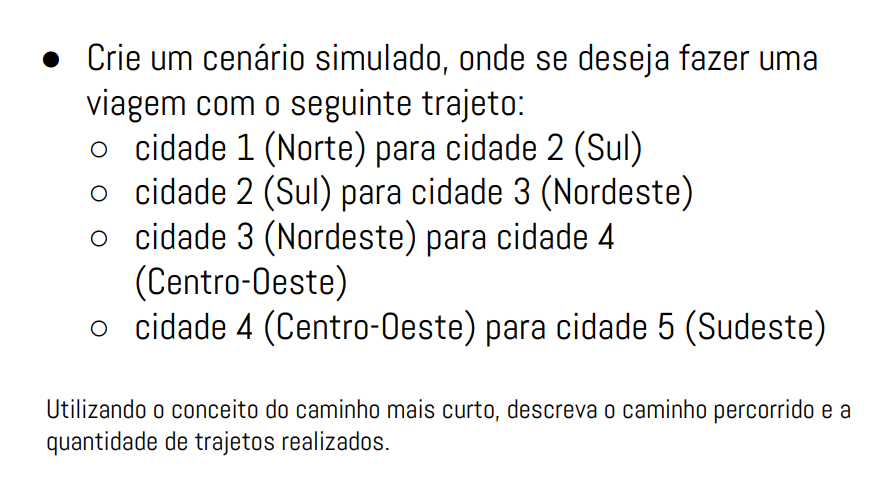

we need to travel using airports from different regions, going from the north to the south, then to the northeast then to the midwest and finally to the south

---

So, for our scenario, imagine that João needs to travel from Manaús/AM to Porto Alegre/RS to take an entrance exam, then he goes to Natal/RN to visit a distant relative, and then goes to the Federal District to get a passport visa to a foreign country and then goes to São Paulo/SP to participate in a job interview at a multinational

In [336]:
#let's reload de graph
G = nx.read_graphml('air_traffic_2.graphml')

#fist list the airports code of each city
print(G.nodes['SBEG'])
print(G.nodes['SBPA'])

# obs. São Gonçalo is the nearest city to Natal
print(G.nodes['SBSG'])
print(G.nodes['SBBR'])
print(G.nodes['SBGR'])

{'name': 'MANAUS', 'country': 'BRASIL', 'latitude': '-3.03861', 'longitude': '-60.049702', 'region': 'NORTE'}
{'name': 'PORTO ALEGRE', 'country': 'BRASIL', 'latitude': '-29.994400024414062', 'longitude': '-51.1713981628418', 'region': 'SUL'}
{'name': 'SÃO GONÇALO DO AMARANTE', 'country': 'BRASIL', 'latitude': '-5.768056', 'longitude': '-35.376111', 'region': 'NORDESTE'}
{'name': 'BRASÍLIA', 'country': 'BRASIL', 'latitude': '-15.869167', 'longitude': '-47.920834', 'region': 'CENTRO-OESTE'}
{'name': 'GUARULHOS', 'country': 'BRASIL', 'latitude': '-23.435556411743164', 'longitude': '-46.47305679321289', 'region': 'SUDESTE'}


In [351]:
#now, using the shortest path concept let's see the path to each city

print("Have direct connection between", G.nodes["SBEG"]["name"], "and", G.nodes["SBPA"]["name"] if nx.has_path(G, 'SBEG', 'SBPA') else "No have direct connection")

#So, the shortest route is a 1-flight trip.
print("flight between:", nx.shortest_path(G, "SBEG", "SBPA"))

Have direct connection between MANAUS and PORTO ALEGRE
flight between: ['SBEG', 'SBPA']


In [350]:
#now from SBPA and SBSG
print("Have direct connection between", G.nodes["SBPA"]["name"], "and", G.nodes["SBSG"]["name"] if nx.has_path(G, 'SBPA', 'SBSG') else "No have direct connection")
#So, the shortest route is a 1-flight trip.
print("flight between:", nx.shortest_path(G, "SBEG", "SBPA"))

Have direct connection between PORTO ALEGRE and SÃO GONÇALO DO AMARANTE
flight between: ['SBEG', 'SBPA']


In [348]:
#now from SBSG and SBBR
print("Have direct connection between", G.nodes["SBSG"]["name"], "and", G.nodes["SBBR"]["name"] if nx.has_path(G, 'SBSG', 'SBBR') else "No have direct connection")
#So, the shortest route is a 1-flight trip.
print("flight between:", nx.shortest_path(G, "SBSG", "SBBR"))

Have direct connection between SÃO GONÇALO DO AMARANTE and BRASÍLIA
flight between: ['SBSG', 'SBBR']


In [353]:
#now from SBBR and SBGR
print("Have direct connection between", G.nodes["SBBR"]["name"], "and", G.nodes["SBGR"]["name"] if nx.has_path(G, 'SBBR', 'SBGR') else "No have direct connection")
#So, the shortest route is a 1-flight trip.
print("flight between:", nx.shortest_path(G, "SBBR", "SBGR"))

Have direct connection between BRASÍLIA and GUARULHOS
flight between: ['SBBR', 'SBGR']


I randomly chose locations, but all trips were between direct flights in each city.😢

# FIFTH ANALYSIS
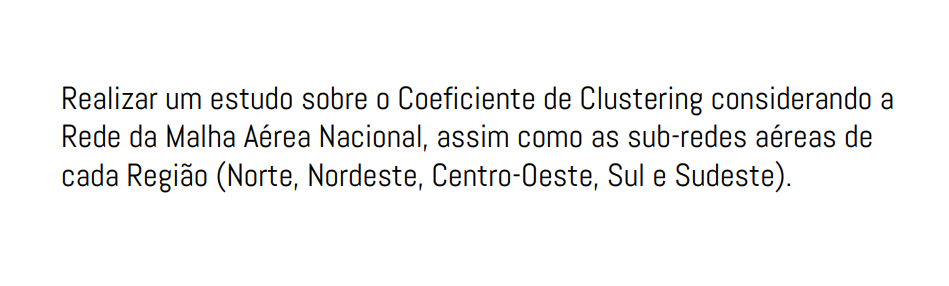

by definition, Clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together.

So, let's use the Clustering function networkx to measure Brazil and each region

In [355]:
#first see the average of clustering of the graph

print(nx.average_clustering(G))

0.623050800236936


In [376]:
#Then see the most clustered node
max_clt = max(nx.clustering(G))
value_clt= max(nx.clustering(G).values())
print(value_clt,"value to", max_clt,':' ,G.nodes[max_clt])


1.0 value to SSZW : {'name': 'PONTA GROSSA', 'country': 'BRASIL', 'latitude': '-25.1847', 'longitude': '-50.1441', 'region': 'SUL'}


In [385]:
clustering = {'region': [], 'value': []}
#now for each region
#first we separate each region into sub graphs and calculate de degree anda average.
G = nx.read_graphml('air_traffic_2.graphml')

#to the North
norte = [node for node, data in G.nodes(data=True) if data['region'] != 'NORTE' ]
G.remove_nodes_from(norte)
north_max_clt = max(nx.clustering(G))
north_value_clt= max(nx.clustering(G).values())

clustering['region'].append(('NORTH: ', north_max_clt))
clustering['value'].append(north_value_clt)


#there are changes in the graph G, we will reload, and this will happen in each region
G = nx.read_graphml('air_traffic_2.graphml')

#to the North East
nordeste = [node for node, data in G.nodes(data=True) if data['region'] != 'NORDESTE' ]
northeast_max_clt = max(nx.clustering(G))
northeast_value_clt= max(nx.clustering(G).values())

clustering['region'].append(('NORTHEAST: ', northeast_max_clt))
clustering['value'].append(northeast_value_clt)
#reload
G = nx.read_graphml('air_traffic_2.graphml')


#to the Midwest
centrooeste = [node for node, data in G.nodes(data=True) if data['region'] != 'CENTRO-OESTE' ]
G.remove_nodes_from(centrooeste)

midwest_max_clt = max(nx.clustering(G))
midwest_value_clt= max(nx.clustering(G).values())
clustering['region'].append(('MIDWEST: ', midwest_max_clt))
clustering['value'].append(midwest_value_clt)
#reload
G = nx.read_graphml('air_traffic_2.graphml')

#to the South East
sudeste = [node for node, data in G.nodes(data=True) if data['region'] != 'SUDESTE' ]
G.remove_nodes_from(sudeste)
southeast_max_clt = max(nx.clustering(G))
southeast_value_clt= max(nx.clustering(G).values())
clustering['region'].append(('SOUTHEAST: ', southeast_max_clt))
clustering['value'].append(southeast_value_clt)


#reload
G = nx.read_graphml('air_traffic_2.graphml')

#to the South
sul = [node for node, data in G.nodes(data=True) if data['region'] != 'SUL' ]
G.remove_nodes_from(sul)
south_max_clt = max(nx.clustering(G))
south_value_clt= max(nx.clustering(G).values())
clustering['region'].append(('south: ', south_max_clt))
clustering['value'].append(south_value_clt)


print(pd.DataFrame(clustering))

,region,value
0,"(NORTH: , SWYN)",1.0
1,"(NORTHEAST: , SWZM)",1.0
2,"(MIDWEST: , SWZM)",1.0
3,"(SOUTHEAST: , SWLF)",1.0
4,"(south: , SSZW)",1.0


In [423]:
G = nx.read_graphml('air_traffic_2.graphml')

cluster = [(key,value) for (key, value) in nx.clustering(G).items() if value==1.0]
print(len(cluster))


125


**Conclusion**<p>
As we can see, each region has at least one airport with a cluster coefficient equal to 1.
This means that we have airports with the formation of communities that connect and form multiple paths, enabling path redundancies, thus preventing air traffic between airports on the same route.


we have 125 cluster airports.